In [6]:
###Imports###
from multiprocessing import Pool

import matplotlib.pyplot as plt
#General
import numpy as np
import pandas as pd
import seaborn as sns

#SALib 
from SALib.analyze import fast
from SALib.sample import fast_sampler

import sys
sys.path.append('lib/')
from lib.utils import *

In [7]:
### Data and parameter imports ###

# Excel file with parameters for easy review and modification
df_par = pd.read_excel('parameters/parameters.xlsx',sheet_name='py')

# Load murine data for model training and plotting
df_data = pd.read_excel('data/Limited Murine Data.xlsx')

### Labels for every state in ODE system ###

# Pathogen label(s)
Pathogen = ['V']

# Host Epithelial Cells
Host = ['S', 'E', 'R', 'I', 'D']

# Cytokines, Chemokines
Cyto = ['IFNA', 'IFNB', 'IFNG', 'IL6', 'GMCSF', 'TNFA', 'MCP1']

# Immune Cells
Immune = ['N', 'MA', 'MI', 'CD8T', 'CD8TK', 'NKIFNG', 'TIFNG', 'TM', 'IFNAP', 'IFNBP']

# Combined list of all states
state_labels = Pathogen + Host + Cyto + Immune


# What timespan should the integration be performed over?
tspan = [0, 13]

### Initial Conditions for ODEs ###

y0 = np.zeros(len(state_labels))

# Initially 1E7 susceptible cells
# Find the index of the state label 'S' in the state_labels list
# Set the corresponding y0 value to 1E7
y0[state_labels.index('S')] = 1E7

# Initially 75 eclipse cells
y0[state_labels.index('E')] = 75

# Initially 93325 Alveolar Macrophages
y0[state_labels.index('MA')] = 93325

print('Model has', len(state_labels), 'states')

#Dataframe of parameters to be included in sensitivity analysis
sens_parameters = df_par[df_par['Sensitivity']].copy()

#Pack all ODE parameters into a dict
parameters = dict(zip(df_par.labels, df_par.initval))

#How many sensitive parameters are there?
n_sens = sens_parameters.shape[0]

#How many ODE states?
dim = len(state_labels)

#User update
print('Sensitivity Analysis with ' + str(n_sens) + ' parameters.')

Model has 23 states
Sensitivity Analysis with 1 parameters.


(5, 1)


TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'str'

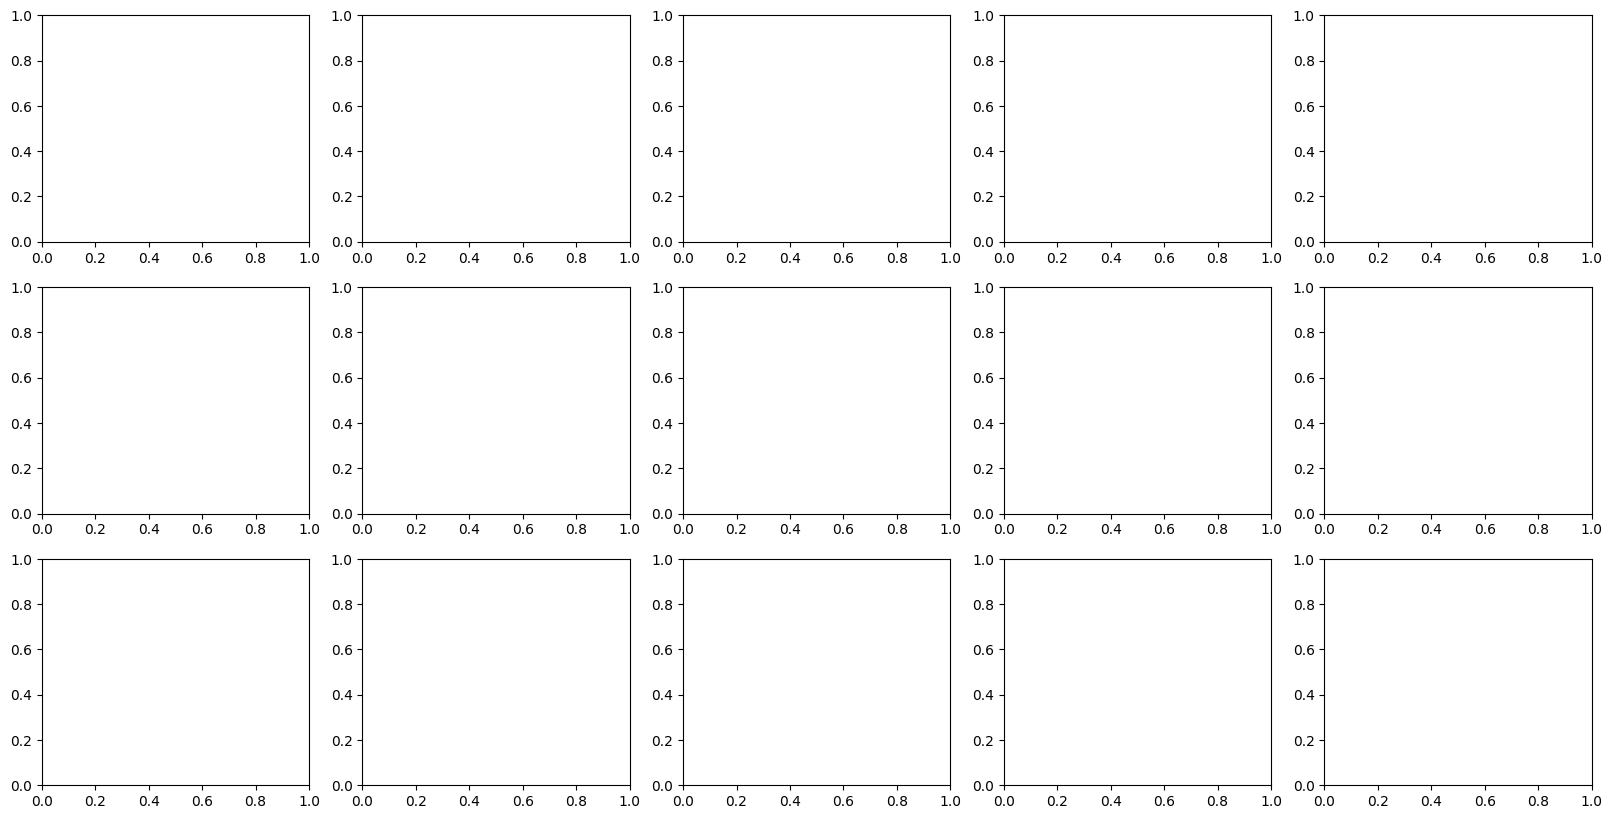

In [8]:
###One At A Time Sampling###
save = False

#What percent should the parameters be analyzed over? 0-1.
sens_percent = 0.5

#Create an empty dataframe 
sens_bnds = pd.DataFrame(columns=['SensMin','SensMax'])

#Calculate the sensitivity max and min values for each parameter
sens_bnds['SensMin'] = sens_parameters['initval']*(1.0-sens_percent)
sens_bnds['SensMax'] = sens_parameters['initval']*(1.0+sens_percent)
bnds = sens_bnds.values.tolist()

# 'normal' or 'log' based sensitivity
sens_type = 'log'

#Pick a number of points to sample
n_points = 5

# Create n_points parameter multipliers, centered at 1.0 (100%)
sens_factors = np.linspace(1.0-sens_percent, 1.0+sens_percent, n_points)

# Create log multiples for parameters - some are only sensitive to log changes
sens_factors_log = np.geomspace(1E-2, 1E2, n_points)

# Find where the center is
idx = np.where(sens_factors == 1.0)[0]

# Move the 1.0 factor to last, to blit black on plots
sens_factors = np.roll(sens_factors, idx - n_points)
sens_factors_log = np.roll(sens_factors_log, idx - n_points)

# Fixed colormap
cmap = ['lime', 'green', 'black', 'firebrick', 'red']

# Apply the same roll operation to the colormap
cmap = np.roll(cmap, idx - n_points)

# Legend from sensFactors
legend = [str(i) for i in sens_factors]

# indexes for legend
leg_idx = np.arange(len(cmap))

# Create colored dummy rectangles for legend
handles = [plt.Rectangle((0, 0), 0, 0, color=cmap[i], label=legend[i]) for i in leg_idx]

# Vary all parameters at once
if sens_type == 'normal':
    paramStack = np.log10([x*sens_parameters['initval'] for x in sens_factors])
else:
    paramStack = np.log10([x*sens_parameters['initval'] for x in sens_factors_log])

print(np.shape(paramStack))

# Create a subplot object to fit all states
rows = 3
cols = 5    
fig, axs = plt.subplots(rows,cols, figsize=(20,10))

for i, (factor, color, leg) in enumerate(zip(sens_factors, cmap, legend)):

    # Evaluate the model
    sol, t_sol = evalModel(Model, parameters, y0, tspan, state_labels, paramStack[i,:], sens_parameters['labels'])
    print('Evaluation complete in', t_sol)
    axs = ModelPlotting(sol, axs, data=df_data, color=color, legend=leg)
    title = ('tau_MI')

fig.suptitle(title)
fig.legend(handles=handles)
if save: fig.savefig('figures/Sensitivity_Sweeps/' + title + '.svg')
plt.tight_layout()
plt.show()

AttributeError: 'set' object has no attribute 'items'

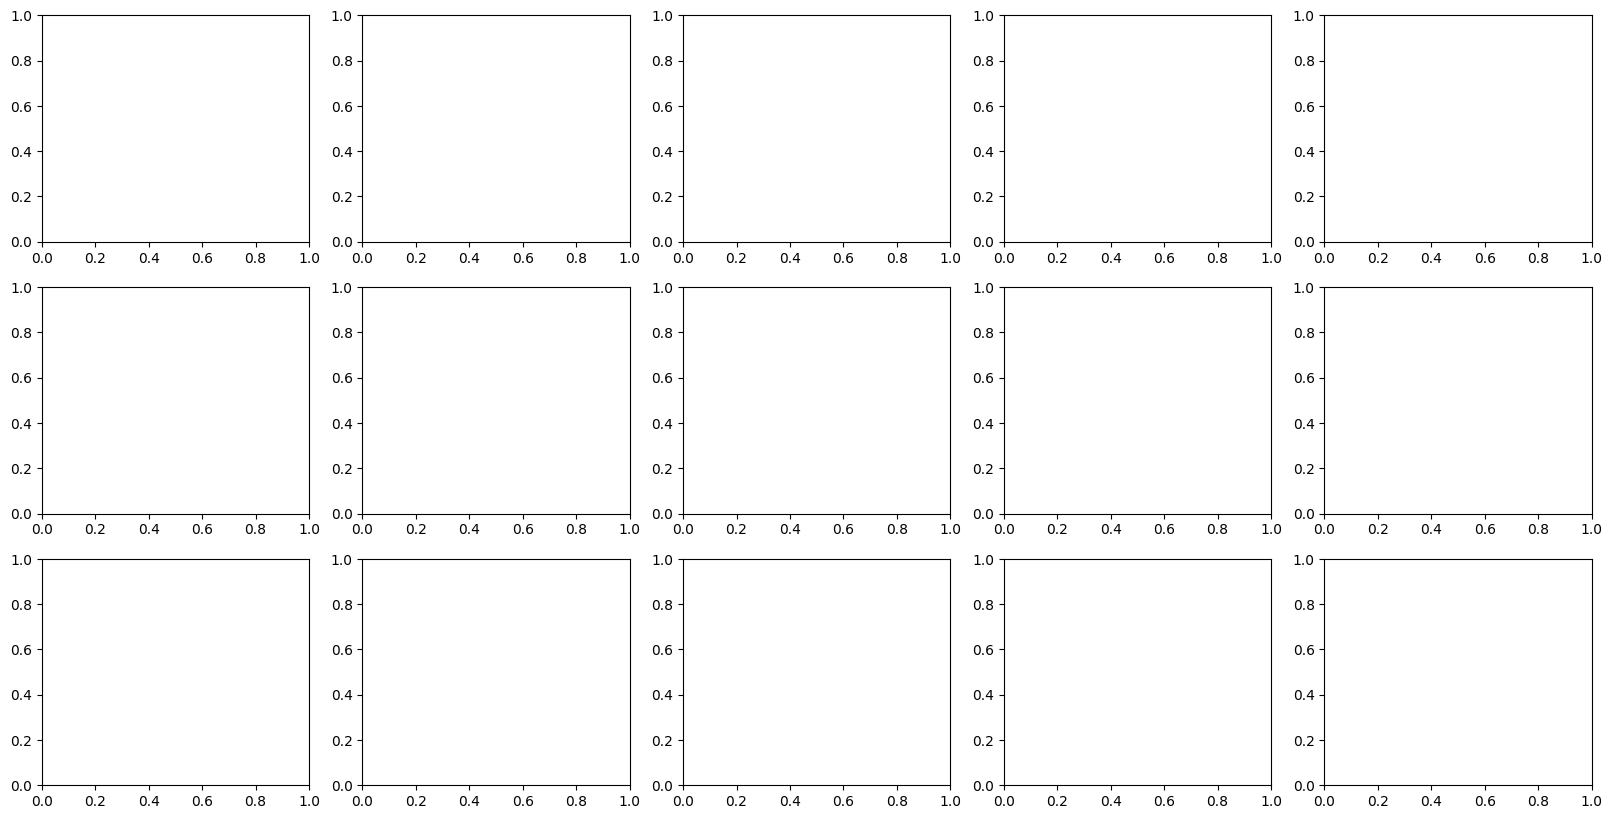

In [ ]:
##Vary one parameter at a time##
for parLabel, parValue in zip(sens_parameters['labels'], sens_parameters['initval']):
    #Create a subplot object to fit all states
    rows = 3
    cols = 5    
    fig, axs = plt.subplots(rows,cols, figsize=(20,10))

    #TODO multiprocessing ode evaluations
    for factor, color, leg in zip(sens_factors, cmap, legend):
        parameterCurrent = np.log10(factor*parValue, dtype='float32')

        #Evaluate the model
        #try:
        sol, Ys = evalModel(y0, Model, parLabel, parameterCurrent, parameters)
        print('Stable solution from parameter ' + parLabel + ' at a value of ' + str(10**parameterCurrent))
        axs = ModelPlotting(sol, axs, data=None, color=color)
        #except:
            #print('Unstable solution from parameter ' + parLabel + ' at a value of ' + str(10**parameterCurrent))
        
        title = (parLabel, 'Sensitivity Sweep')
    fig.legend(loc='upper left', bbox_to_anchor=(0.13, 0.93))
    fig.suptitle(title)
    plt.tight_layout()
 
    if save: fig.savefig('figures/Sensitivity_Sweeps/' + title + '.svg')
    plt.show()

In [1]:
import numpy as np
import pandas as pd
from SALib.analyze import fast
from SALib.sample import fast_sampler
from multiprocessing import Pool
import multiprocessing

# Dummy model function
def Model(parameters):
    # A simple model: sum of squared parameters
    return np.sum(np.square(parameters))

# Sensitivity Metrics function
def SensitivityMetrics(y0, model, labels, parameters, dim, values):
    result = []
    # Modify the parameters based on 'values' and evaluate the model
    modified_params = dict(zip(labels, 10**values))
    model_output = model(list(modified_params.values()))
    # Just dummy operations to create three metrics
    result.append(model_output)  # Placeholder for AUC metric
    result.append(-model_output) # Placeholder for Min metric
    result.append(model_output)  # Placeholder for Max metric
    return result

# Parameters
n_sens = 3
sens_parameters = pd.DataFrame({
    'labels': ['param1', 'param2', 'param3'],
    'initval': [1.0, 1.5, 2.0]
})

# Sensitivity bounds calculation
sens_percent = 0.5
sens_bnds = pd.DataFrame()
sens_bnds['SensMin'] = sens_parameters['initval'] * (1.0 - sens_percent)
sens_bnds['SensMax'] = sens_parameters['initval'] * (1.0 + sens_percent)
bnds = sens_bnds.values.tolist()

# Problem dictionary
problem = {
    'num_vars': n_sens,
    'names': sens_parameters['labels'].tolist(),
    'bounds': bnds
}

# Order of the analysis
order = 4
param_values = fast_sampler.sample(problem, N=65, M=order)

# get core count of computer
n_cores = multiprocessing.cpu_count()

# Evaluate the model in parallel using multiprocessing
if __name__=='__main__':
    with Pool(n_cores-1) as pool:
        Y = pool.starmap(SensitivityMetrics, ((None, Model, sens_parameters['labels'], None, n_sens, np.log10(p)) for p in param_values))

# Transform metrics to an array
Yarray = np.asarray(Y)

# Perform the sensitivity analysis for AUC, Min, and Max
dim = n_sens
AUC = [fast.analyze(problem, Yarray[:,0,x], M=order, num_resamples=100, conf_level=0.95, print_to_console=False) for x in range(dim)]
Min = [fast.analyze(problem, Yarray[:,1,x], M=order, num_resamples=100, conf_level=0.95, print_to_console=False) for x in range(dim)]
Max = [fast.analyze(problem, Yarray[:,2,x], M=order, num_resamples=100, conf_level=0.95, print_to_console=False) for x in range(dim)]

# Printing results for demonstration
print("AUC:", AUC)
print("Min:", Min)
print("Max:", Max)


ModuleNotFoundError: No module named 'SALib'

In [ ]:
### eFAST Sensitivity Analysis ###
from SALib.analyze import fast
from SALib.sample import fast_sampler

#What percent should the parameters be analyzed over? 0-1.
sens_percent = 0.5

#Create an empty dataframe 
sens_bnds = pd.DataFrame(columns=['SensMin','SensMax'])

#Calculate the sensitivity max and min values for each parameter
sens_bnds['SensMin'] = sens_parameters['initval']*(1.0-sens_percent)
sens_bnds['SensMax'] = sens_parameters['initval']*(1.0+sens_percent)
bnds = sens_bnds.values.tolist()

#Problem dictionary
problem = {
    'num_vars': n_sens,
    'names': sens_parameters['labels'],
    'bounds':bnds 
}

order = 4

#Creates sample parameter sets
param_values=fast_sampler.sample(problem, N=65, M=order)

#Evaluate the model at all sets of parameters
if __name__=='__main__':
    with Pool(12) as pool:
        Y = pool.starmap(SensitivityMetrics, ((y0, Model, sens_parameters['labels'], parameters, dim, np.log10([*p])) for p in param_values))

###Perform the sensitivity analysis###
#Transform metrics to an array
Yarray = np.asarray(Y)

#AUC sensitivity analysis
AUC = [fast.analyze(problem, np.asarray(Yarray[:,0,x]), M=order, num_resamples=100, conf_level=0.95, print_to_console=False) for x in range(0,dim)]

#Min sensitivity analysis
Min = [fast.analyze(problem, np.asarray(Yarray[:,1,x]), M=order, num_resamples=100, conf_level=0.95, print_to_console=False) for x in range(0,dim)]

#Max sensitivity analysis
Max = [fast.analyze(problem, np.asarray(Yarray[:,2,x]), M=order, num_resamples=100, conf_level=0.95, print_to_console=False) for x in range(0,dim)]

NameError: name 'Model' is not defined

In [ ]:
###Standard 2D plot sensitivity analysis results###
save = False

#TODO select by sensitivity order

for i in range(0,dim):
    AUCfig = AUC[i].plot()
    name = (str(state_labels[i])+'_AUC')
    AUCfig.set_title(name)
    if save: AUCfig.figure.savefig('figures/Sensitivity_2D/'+name+'.png')

    MINfig = Min[i].plot()
    name = (str(state_labels[i])+'_Min')
    MINfig.set_title(name)
    if save: MINfig.figure.savefig('figures/Sensitivity_2D/'+name+'.png')

    MAXfig = Max[i].plot()
    name = (str(state_labels[i])+'_Max')
    MAXfig.set_title(name)
    if save: MAXfig.figure.savefig('figures/Sensitivity_2D/'+name+'.png')

NameError: name 'AUC' is not defined

In [ ]:
###Sensitivity Heatmaps###
save = False

#TODO make into callable function, move to utils, replace w. appropriate calls

AUC_df = pd.DataFrame([AUC[x]['S1'] for x in range(0,19)])
AUC_df.columns = sens_parameters['labels']
AUC_df.index = state_labels
plt.figure()
axAUC = sns.heatmap(AUC_df[0:])
axAUC.set_title('AUC First Order Sensitivity')
if save: axAUC.figure.savefig('figures/Sensitivity_Heatmaps/AUC S1 heatmap.png')

MIN_df = pd.DataFrame([Min[x]['S1'] for x in range(0,19)])
MIN_df.columns = sens_parameters['labels']
MIN_df.index = state_labels
plt.figure()
axMIN = sns.heatmap(MIN_df[0:])
axMIN.set_title('Min First Order Sensitivity')
if save: axMIN.figure.savefig('figures/Sensitivity_Heatmaps/Min S1 heatmap.png')

MAX_df = pd.DataFrame([Max[x]['S1'] for x in range(0,19)])
MAX_df.columns = sens_parameters['labels']
MAX_df.index = state_labels
plt.figure()
axMAX = sns.heatmap(MAX_df[0:])
axMAX.set_title('Max First Order Sensitivity')
if save: axMAX.figure.savefig('figures/Sensitivity_Heatmaps/Max S1 heatmap.png')

AUC_df = pd.DataFrame([AUC[x]['ST'] for x in range(0,19)])
AUC_df.columns = sens_parameters['labels']
AUC_df.index = state_labels
plt.figure()
axAUC = sns.heatmap(AUC_df[0:])
axAUC.set_title('AUC Total Order Sensitivity')
if save: axAUC.figure.savefig('figures/Sensitivity_Heatmaps/AUC ST heatmap.png')

MIN_df = pd.DataFrame([Min[x]['ST'] for x in range(0,19)])
MIN_df.columns = sens_parameters['labels']
MIN_df.index = state_labels
plt.figure()
axMIN = sns.heatmap(MIN_df[0:])
axMIN.set_title('Min Total Order Sensitivity')
if save: axMIN.figure.savefig('figures/Sensitivity_Heatmaps/Min ST heatmap.png')

MAX_df = pd.DataFrame([Max[x]['ST'] for x in range(0,19)])
MAX_df.columns = sens_parameters['labels']
MAX_df.index = state_labels
plt.figure()
axMAX = sns.heatmap(MAX_df[0:])
axMAX.set_title('Max Total Order Sensitivity')
if save: axMAX.figure.savefig('figures/Sensitivity_Heatmaps/Max ST heatmap.png')

NameError: name 'AUC' is not defined